In [1]:
import matplotlib
from matplotlib import pyplot
import torch
print(torch.__version__)

1.0.0


In [2]:
class Reversible(torch.nn.Module):
    def forward(self, x):
        pass

    def reverse(self, y):
        pass
    
    def __call__(self, x):
        y, logdet = super().__call__(x)
        assert logdet.shape == ()
        setattr(y, "flow_fn", self)
        return y, logdet
    

def population(x):
    """assume x [batch, shape0, shape1, ..., feat]"""
    n = 1
    for i in x.shape[1:-1]:
        n *= i
    return n


class ActNorm(Reversible):
    def __init__(self, n, data_init=True, eps=1e-6):
        super().__init__()
        self.scale = torch.nn.Parameter(torch.ones(n))
        self.bias = torch.nn.Parameter(torch.zeros(n))
        self.eps = eps
        self.data_init = data_init
    
    def forward(self, x):
        xf = x.view(-1, x.shape[-1])
        if self.data_init:
            self.scale[:] = 1 / (xf.std(dim=0) + self.eps)
            self.bias[:] = -xf.mean(dim=0)
            self.data_init = False
        return self.scale * x + self.bias, self.logdet(x)

    def reverse(self, y):
        return (y - self.bias) / self.scale, self.logdet(y)
    
    def logdet(self, x):
        return population(x) * self.scale.log().sum()

In [3]:
f = ActNorm(5)
x = torch.rand(2, 3, 4, 5)
y, logdet = f(x)
rx, rlogdet = f.reverse(y)
torch.testing.assert_allclose(rx, x)
torch.testing.assert_allclose(rlogdet, logdet)
logdet

tensor(76.1936, grad_fn=<MulBackward0>)

In [4]:
class Linear(Reversible):
    def __init__(self, n):
        super().__init__()
        # invertible initialization
        q, r = torch.randn(n, n).qr()
        self.weight = torch.nn.Parameter(q)
        
    def forward(self, x):
        return x.matmul(self.weight), self.logdet(x)
    
    def reverse(self, y):
        return y.matmul(self.weight.inverse()), self.logdet(y)
    
    def logdet(self, x):
        return population(x) * self.weight.det().abs().log()       

In [5]:
f = Linear(5)
x = torch.randn(2, 3, 4, 5)
y, logdet = f(x)
rx, rlogdet = f.reverse(y)
torch.testing.assert_allclose(rx, x)
torch.testing.assert_allclose(rlogdet, logdet)
logdet

tensor(1.4305e-06, grad_fn=<MulBackward0>)

In [6]:
def half(x):
    assert x.shape[-1] % 2 == 0
    return x.split(x.shape[-1] // 2, dim=-1)


class AffineCoupling(Reversible):
    def __init__(self, net, additive=True):
        super().__init__()
        self.net = net
        self.additive = additive
        
    def forward(self, x):
        x_a, x_b = half(x)
        if self.additive:
            y_a = x_a + self.net(x_b)
            logdet = torch.tensor(0.0)
        else:
            log_s, t = half(self.net(x_b))
            y_a = log_s.exp() * x_a + t
            logdet = log_s.sum()
        return torch.cat((y_a, x_b), dim=-1), logdet
        
    def reverse(self, y):
        y_a, y_b = half(y)
        if self.additive:
            x_a = y_a - self.net(y_b)
            logdet = torch.tensor(0.0)
        else:
            log_s, t = half(self.net(y_b))
            x_a = (y_a - t) / log_s.exp()
            logdet = log_s.sum()
        return torch.cat((x_a, y_b), dim=-1), logdet

In [7]:
f = AffineCoupling(torch.nn.Linear(3, 6), additive=False)
x = torch.randn(2, 3, 4, 6)
y, logdet = f(x)
rx, rlogdet = f.reverse(y)
torch.testing.assert_allclose(rx, x)
torch.testing.assert_allclose(rlogdet, logdet)
logdet

tensor(-5.5365, grad_fn=<SumBackward0>)

In [8]:
f = AffineCoupling(torch.nn.Linear(3, 3), additive=True)
x = torch.randn(2, 3, 4, 6)
y, logdet = f(x)
torch.testing.assert_allclose(f.reverse(y)[0], x)
logdet

tensor(0.)

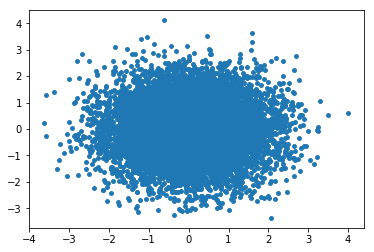

In [20]:
from torch.distributions import Normal, MultivariateNormal

def doublemoon_sample(n_sample):
    x1_1 = Normal(4, 4)
    sampled_x1_1 = x1_1.sample((int(n_sample/2),))
    x2_1 = Normal(0.25*(sampled_x1_1-4)**2-20, torch.ones_like(sampled_x1_1)*2)
    sampled_x2_1 = x2_1.sample()

    x1_2 = Normal(-4, 4)
    sampled_x1_2 = x1_2.sample((int(n_sample/2),))
    x2_2 = Normal(-0.25*(sampled_x1_2+4)**2+20, torch.ones_like(sampled_x1_2)*2)
    sampled_x2_2 = x2_2.sample()

    sampled_x1 = torch.cat([sampled_x1_1, sampled_x1_2])
    sampled_x2 = torch.cat([sampled_x2_1, sampled_x2_2])
    sampled_x = torch.zeros(n_sample, 2)
    sampled_x[:,0] = sampled_x1*0.2
    sampled_x[:,1] = sampled_x2*0.1    
    return sampled_x

n_sample = 10000
z = MultivariateNormal(torch.zeros(2), torch.eye(2))
sampled_z = z.sample((n_sample,))
pyplot.scatter(sampled_z[:,0], sampled_z[:,1], s=15)

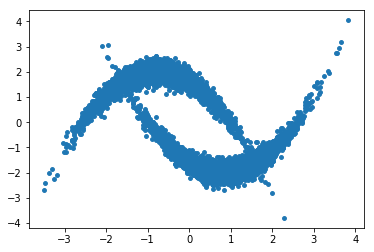

In [21]:
sampled_x = doublemoon_sample(n_sample)
pyplot.scatter(sampled_x[:,0],sampled_x[:,1], s=15)

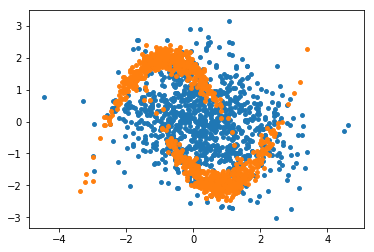

In [25]:
def mlp(n_in, n_hid, n_out):
    ret = torch.nn.Sequential(
        torch.nn.Linear(n_in, n_hid),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hid, n_hid),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hid, n_out)
    )
#     with torch.no_grad():
#         ret[-1].weight.zero_()
#         ret[-1].bias.zero_()
    return ret


class RealNVP(torch.nn.Module):
    def __init__(self, n_in, n_hid=256, n_layers=4, additive=False):
        super().__init__()
        n_out = n_in // 2 if additive else n_in
        self.list = torch.nn.ModuleList(
            [AffineCoupling(mlp(n_in // 2, n_hid, n_out), additive) for _ in range(n_layers)])

    def forward(self, x):
        sum_logdet = 0
        z = x
        for m in self.list:
            z, logdet = m(z)
            sum_logdet += logdet
        return z, sum_logdet
    
    def reverse(self, z):
        sum_logdet = 0
        x = z
        for m in reversed(self.list):
            x, logdet = m.reverse(x)
            sum_logdet += logdet
        return x, sum_logdet


model = RealNVP(2)
sampled_x = doublemoon_sample(1000)
test_z = z.sample((1000,))
with torch.no_grad():
    trans_z = model(sampled_x)[0]
    rev_x = model.reverse(trans_z)[0]
    test_x, logdet = model.reverse(test_z)
torch.testing.assert_allclose(sampled_x, rev_x)
pyplot.scatter(test_x[:, 0], test_x[:, 1], s=15)
pyplot.scatter(sampled_x[:,0],sampled_x[:,1], s=15)

3.4411292698732607
3.3990668400078063
3.387377237818044
3.4272943104907965
3.366943494529481
3.3726174816204484
3.3848129974049366
3.3688727290767013
3.3753551920508125
3.3625062848352325
3.3703391324182985
3.381315120466196
3.394454198278439
3.355485135582602
3.3598334348885115
3.356803395945555
3.3484380837458714
3.3541848644329484
3.356842809422001
3.3537178069922575
3.3574146966266025
3.3575329871693995
3.3505302508165884
3.3536334204825624
3.3540213563639645
3.3613043727388807
3.3524780637899023
3.3570771627365406
3.3490340831173455
3.3481418160116596


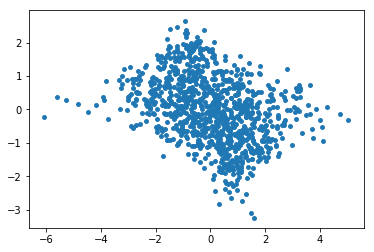

In [26]:
from torch.utils.data import DataLoader
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
sum_loss = 0
model.train()
xs = doublemoon_sample(10000)
train_loader = DataLoader(xs, batch_size=64, shuffle=True)
for i in range(30):
    for x in train_loader:
        # sampled_x = doublemoon_sample(64)
        transformed, sum_logdet = model(x)
        loss = -(z.log_prob(transformed).sum() + sum_logdet) / x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
    print(sum_loss / len(train_loader))
    sum_loss = 0

sampled_x = doublemoon_sample(1000)
test_z = z.sample((1000,))
with torch.no_grad():
    test_x, logdet = model.reverse(test_z)
pyplot.scatter(test_x[:, 0], test_x[:, 1], s=15)
# pyplot.scatter(sampled_x[:,0],sampled_x[:,1], s=15)